Phase 1: Step 1 - Load Dataset

In [10]:
import pandas as pd
import glob 
import os

In [11]:
DATASET_DIR = "python_files/"

# Use glob to find all CSVs that match the pattern
csv_files = sorted(glob.glob(os.path.join(DATASET_DIR, "python_files_*.csv")))

print(f"Found {len(csv_files)} files.")

# Load and clean all files
dfs = []
for f in csv_files:
    print(f"Loading {f} ...")
    df_part = pd.read_csv(
        f,
        dtype=str,
        keep_default_na=False
    )
    # Standardize schema
    df_part.columns = df_part.columns.str.strip().str.lower()
    df_part['repo_name'] = df_part['repo_name'].str.strip().str.lower()
    df_part['path'] = df_part['path'].str.strip()
    df_part['sha'] = df_part['sha'].str.strip().str.lower()
    
    dfs.append(df_part)

# Merge all parts into one DataFrame
df = pd.concat(dfs, ignore_index=True)


Found 10 files.
Loading python_files/python_files_000000000000.csv ...
Loading python_files/python_files_000000000001.csv ...
Loading python_files/python_files_000000000002.csv ...
Loading python_files/python_files_000000000003.csv ...
Loading python_files/python_files_000000000004.csv ...
Loading python_files/python_files_000000000005.csv ...
Loading python_files/python_files_000000000006.csv ...
Loading python_files/python_files_000000000007.csv ...
Loading python_files/python_files_000000000008.csv ...
Loading python_files/python_files_000000000009.csv ...


In [12]:
# Preview
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset shape: (27001763, 3)
Columns: ['repo_name', 'path', 'sha']


,repo_name,path,sha
0,polaris/boids,lib/googletest-82b11b8/googlemock/scripts/gene...,359d5562d78cf92abafdd2b9f1ef64ef05f547bd
1,polaris/boids,lib/googletest-82b11b8/googlemock/scripts/uplo...,6e6f9a14719ef8c9fdb603ad50bdd35dc7996e2d
2,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_t...,5678ffeaf6fa61ef7dcb45b8f34a0341191abf6e
3,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_o...,d5c637b4c1a5400bd7b4fdcf7ed786e7d40c3e6c
4,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_s...,30d0303d193554a5fd0b9b1f6a51ef7d09f30612


Phase 1: Step 2 - Data Integrity Check with Logging 

In [20]:
import re

In [18]:
#Keep a list of invalid paths
removed_entries = []

def log_invalid(df_subset, reason):
    """Helper to tag invalid rows with reason for removal"""
    temp = df_subset.copy()
    temp['invalid_reason'] = reason
    return temp

In [21]:
# --- 1. Remove exact duplicates ---
initial_count = len(df)

duplicates = df[df.duplicated(subset=["repo_name", "path", "sha"], keep="first")]
if not duplicates.empty:
    removed_entries.append(log_invalid(duplicates, "duplicate_repo_path_sha"))
df = df.drop_duplicates(subset=["repo_name", "path", "sha"], keep="first")

# Remove duplicate SHAs
dup_shas = df[df.duplicated(subset=["sha"], keep="first")]
if not dup_shas.empty:
    removed_entries.append(log_invalid(dup_shas, "duplicate_sha"))
df = df.drop_duplicates(subset=["sha"], keep="first")


In [22]:
# --- 2. Validate SHA format ---
def is_valid_sha(s):
    return bool(re.fullmatch(r"[0-9a-f]{40}", str(s)))

invalid_sha = df[~df['sha'].apply(is_valid_sha)]
if not invalid_sha.empty:
    removed_entries.append(log_invalid(invalid_sha, "invalid_sha"))
df = df[df['sha'].apply(is_valid_sha)]


In [23]:
# --- 3. Validate file extensions ---
valid_py_mask = df['path'].str.lower().str.endswith(".py")
invalid_ext = df[~valid_py_mask]
if not invalid_ext.empty:
    removed_entries.append(log_invalid(invalid_ext, "invalid_extension"))
df = df[valid_py_mask].copy()

In [25]:
# --- Compile removal log ---
if removed_entries:
    removal_log = pd.concat(removed_entries, ignore_index=True)
else:
    removal_log = pd.DataFrame(columns=df.columns.tolist() + ["removal_reason"])


In [27]:
print("===== Cleaning Summary =====")
print(f"Initial entries: {initial_count}")
print(f"Final entries:   {len(df)}")
print(f"Total removed:   {len(removal_log)}\n")

print("Removal breakdown by reason:")
print(removal_log['removal_reason'].value_counts())

# Save for traceability
removal_log.to_csv("invalid_entries_log.csv", index=False)

df.head()

===== Cleaning Summary =====
Initial entries: 7522004
Final entries:   7522004
Total removed:   0

Removal breakdown by reason:
Series([], Name: count, dtype: int64)


,repo_name,path,sha
0,polaris/boids,lib/googletest-82b11b8/googlemock/scripts/gene...,359d5562d78cf92abafdd2b9f1ef64ef05f547bd
1,polaris/boids,lib/googletest-82b11b8/googlemock/scripts/uplo...,6e6f9a14719ef8c9fdb603ad50bdd35dc7996e2d
2,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_t...,5678ffeaf6fa61ef7dcb45b8f34a0341191abf6e
3,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_o...,d5c637b4c1a5400bd7b4fdcf7ed786e7d40c3e6c
4,polaris/boids,lib/googletest-82b11b8/googletest/test/gtest_s...,30d0303d193554a5fd0b9b1f6a51ef7d09f30612


se 1: Step 3 - General Dataset Info

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

===== Dataset Summary =====
Total entries: 7522004
Unique repos: 468348
Unique files: 5104007
Unique SHAs:  7522004

Files per repo (summary stats):
count    468348.000000
mean         16.060301
std          77.261473
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       24189.000000
Name: path, dtype: float64


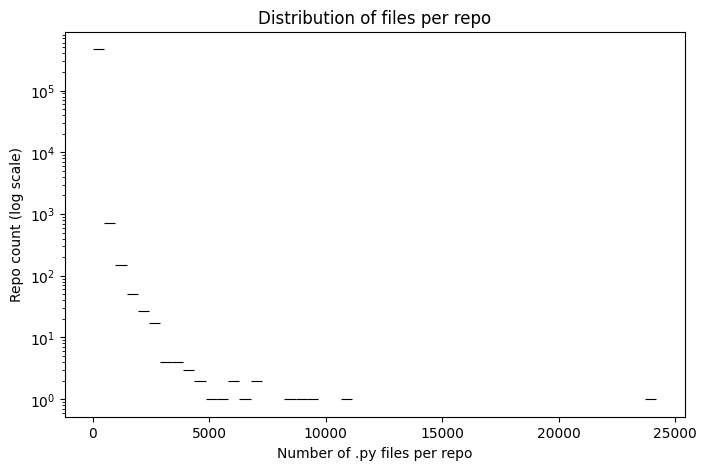

In [31]:
print("===== Dataset Summary =====")
print(f"Total entries: {len(df)}")
print(f"Unique repos: {df['repo_name'].nunique()}")
print(f"Unique files: {df['path'].nunique()}")
print(f"Unique SHAs:  {df['sha'].nunique()}")

# --- Distribution of files per repo ---
files_per_repo = df.groupby("repo_name")["path"].nunique()
print("\nFiles per repo (summary stats):")
print(files_per_repo.describe())

plt.figure(figsize=(8,5))
sns.histplot(files_per_repo, bins=50, log_scale=(False, True))
plt.xlabel("Number of .py files per repo")
plt.ylabel("Repo count (log scale)")
plt.title("Distribution of files per repo")
plt.show()